In [2]:
import numpy as np
from gradvi.priors import Ash
from gradvi.inference import  LinearRegression
from gradvi.models import  LinearModel
from gradvi.tests import toy_data, toy_priors
from mrashpen.models.mixture_gaussian import emfit

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 72)

In [3]:
X, y, b, s2 = toy_data.get_linear_model(n = 200, p = 500, p_causal = 10, pve = 0.6, rho = 0)
prior = toy_priors.get_ash_scaled()

wtrue = emfit(b, prior.sk)
prior.update_w(wtrue)

In [4]:
objtype = 'reparametrize'
gv1 = LinearRegression(obj = objtype, optimize_s = False, optimize_w = False)
gv1.fit(X, y, prior, s2_init = s2)

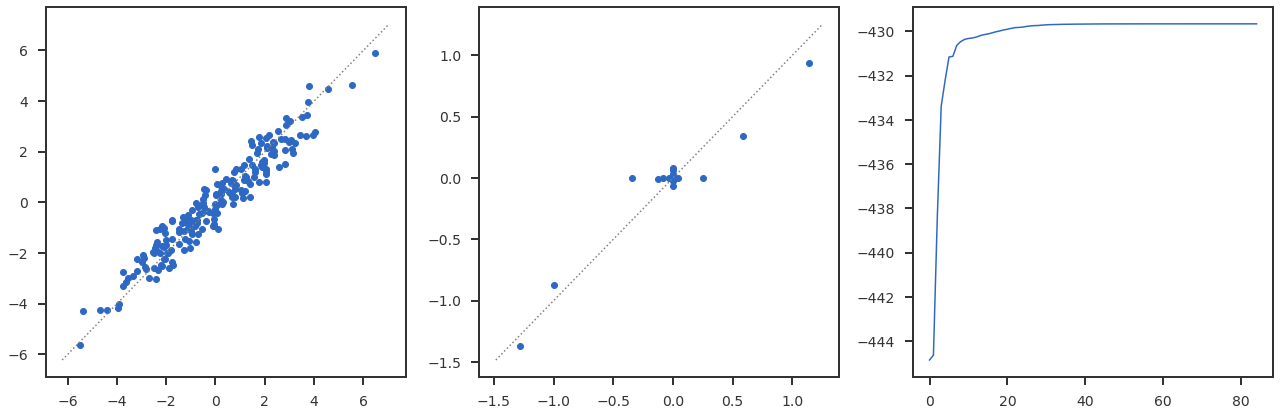

In [5]:
fig = plt.figure(figsize = (18, 6))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
ax1.scatter(np.dot(X, b), np.dot(X, gv1.coef))
ax2.scatter(b, gv1.coef)
#ax3.scatter(np.arange(gv1.niter - 1), np.log(gv1.elbo_path[:-1] - gv1.elbo_path[-1]))
ax3.plot(np.arange(gv1.niter), - gv1.elbo_path)
mpl_utils.plot_diag(ax1)
mpl_utils.plot_diag(ax2)
plt.tight_layout()
plt.show()

In [6]:
gv2 = LinearRegression(obj = objtype, method = 'cg', optimize_s = False, optimize_w = False)
gv2.fit(X, y, prior, s2_init = s2)

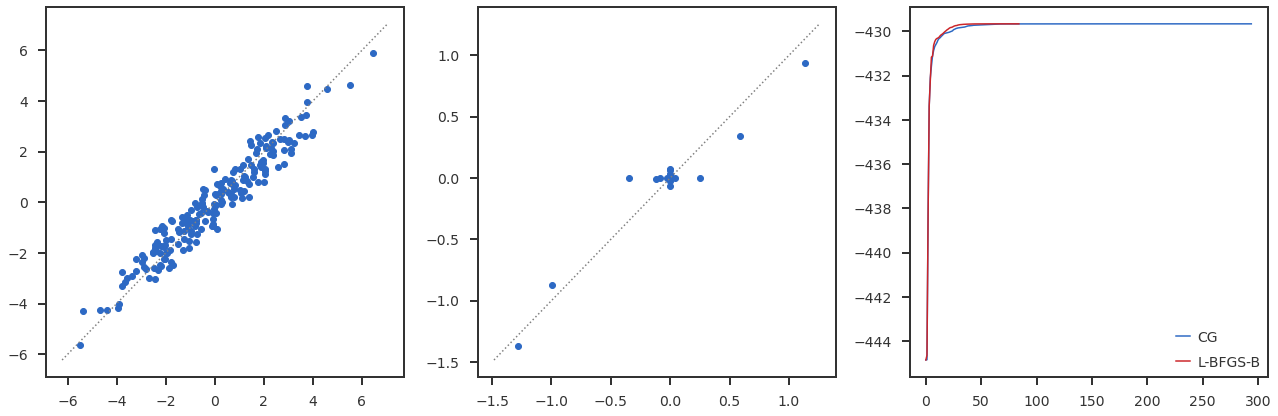

In [7]:
fig = plt.figure(figsize = (18, 6))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
ax1.scatter(np.dot(X, b), np.dot(X, gv2.coef))
ax2.scatter(b, gv2.coef)
#ax3.scatter(np.arange(gv1.niter - 1), np.log(gv1.elbo_path[:-1] - gv1.elbo_path[-1]))
ax3.plot(np.arange(gv2.niter), - gv2.elbo_path, label = 'CG')
ax3.plot(np.arange(gv1.niter), - gv1.elbo_path, label = 'L-BFGS-B')
ax3.legend()
mpl_utils.plot_diag(ax1)
mpl_utils.plot_diag(ax2)
plt.tight_layout()
plt.show()

In [8]:
gv3 = LinearRegression(obj = objtype, method = 'newton-cg', optimize_s = False, optimize_w = False)
gv3.fit(X, y, prior, s2_init = s2)

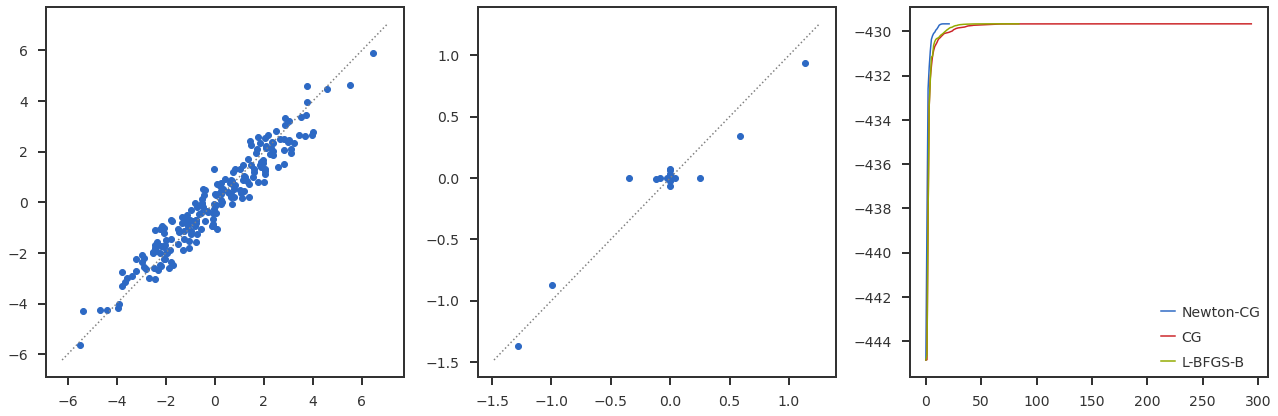

In [9]:
fig = plt.figure(figsize = (18, 6))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
ax1.scatter(np.dot(X, b), np.dot(X, gv3.coef))
ax2.scatter(b, gv3.coef)
#ax3.scatter(np.arange(gv1.niter - 1), np.log(gv1.elbo_path[:-1] - gv1.elbo_path[-1]))
ax3.plot(np.arange(gv3.niter), - gv3.elbo_path, label = 'Newton-CG')
ax3.plot(np.arange(gv2.niter), - gv2.elbo_path, label = 'CG')
ax3.plot(np.arange(gv1.niter), - gv1.elbo_path, label = 'L-BFGS-B')
ax3.legend()
mpl_utils.plot_diag(ax1)
mpl_utils.plot_diag(ax2)
plt.tight_layout()
plt.show()

In [12]:
def hessian_func(params):
    lm = LinearModel(X, y, params, s2, prior, objtype = objtype)
    nm = lm.get_normal_means_model()
    Mb, Mb_bgrad, Mb_wgrad, Mb_sj2grad, Mb_bgrad2 = nm.shrinkage_operator(jac = True, hess = True)
    lj, l_bgrad,  l_wgrad,  l_sj2grad, l_bgrad2  = nm.penalty_operator(jac = True, hess = True)

    r    = lm._y - lm.Xdotv(Mb)
    rTX  = lm.XTdotv(r)

    H = np.dot(lm._X.T, lm._X) * np.outer(Mb_bgrad, Mb_bgrad) / lm._s2
    H[np.diag_indices_from(H)] += l_bgrad2 - (rTX * Mb_bgrad2 / lm._s2)
    return H

In [13]:
gv4 = LinearRegression(obj = objtype, method = 'newton-cg', hessian_callable = hessian_func,
                       optimize_s = False, optimize_w = False)
gv4.fit(X, y, prior, s2_init = s2)

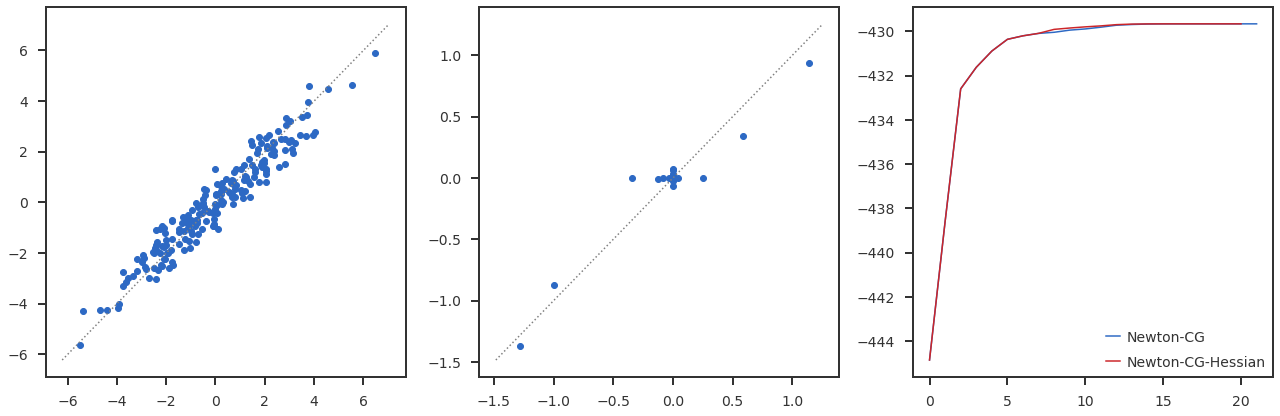

In [15]:
fig = plt.figure(figsize = (18, 6))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
ax1.scatter(np.dot(X, b), np.dot(X, gv4.coef))
ax2.scatter(b, gv4.coef)

ax3.plot(np.arange(gv3.niter), - gv3.elbo_path, label = 'Newton-CG')
ax3.plot(np.arange(gv4.niter), - gv4.elbo_path, label = 'Newton-CG-Hessian')

ax3.legend()
mpl_utils.plot_diag(ax1)
mpl_utils.plot_diag(ax2)
plt.tight_layout()
plt.show()